<a href="https://colab.research.google.com/github/Erfan6561/VKR/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%961_(ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <font color="green">Комплекс из трёх лабораторных работ, по классификации изображений разными типами нейронных сетей с использованием Hugging Face</font>

---

# <font color="green">Лабораторная работа №1, [ResNet50](https://huggingface.co/docs/transformers/model_doc/resnet)</font>

---




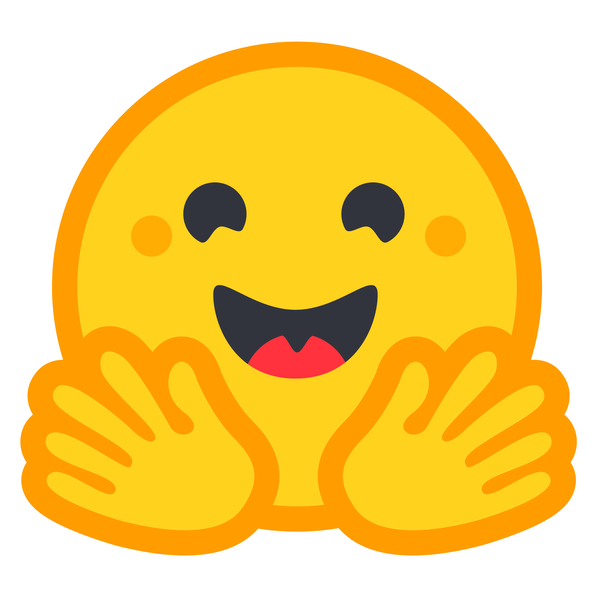

# <font color="green">Цель данной работы - научиться классифицировать изображения с использованием [ResNet50](https://huggingface.co/docs/transformers/model_doc/resnet), используя библиотеки Hugging Face. Также изучим все нюансы и подводные камни</font>

[ResNet50](https://huggingface.co/docs/transformers/model_doc/resnet) — это 50-слойная сверточная нейронная сеть, разработанная для эффективного обучения глубоких моделей благодаря использованию остаточных блоков с пропускными связями, которые решают проблему затухания градиентов. Архитектура включает 49 свёрточных и один полносвязный слой, применяет Batch Normalization и ReLU для стабилизации обучения. Сеть широко используется в компьютерном зрении для классификации изображений, детекции объектов и сегментации, сочетая высокую точность с разумными вычислительными затратами, что делает её популярной в практических приложениях.

### Шаг 1. Установка и импорт зависимостей

- Устанавливаем необходимые библиотеки для машинного обучения (PyTorch, Transformers, Datasets и др.).

- Импортируем основные модули для работы с нейросетями, данными и визуализацией.

- Готовим инструменты для загрузки датасета (CIFAR-100) и оценки точности модели.

(Для чего каждая зависимость подробнее описано в коде)

In [ ]:
# Установка последних версий необходимых библиотек с помощью pip (флаг -q для тихого режима)
!pip install --upgrade transformers datasets accelerate huggingface_hub torch torchvision -q

# Импорт библиотеки PyTorch для работы с тензорами и нейронными сетями
import torch
# Импорт модуля нейронных сетей из PyTorch
import torch.nn as nn
# Импорт библиотеки NumPy для работы с числовыми массивами
import numpy as np
# Импорт библиотеки matplotlib для визуализации данных и графиков
import matplotlib.pyplot as plt
# Импорт модуля для работы со случайными числами
import random
# Импорт модуля для работы с изображениями из библиотеки PIL
from PIL import Image

# Загрузка датасетов из библиотеки Hugging Face datasets
from datasets import load_dataset    # Берём CIFAR-100 из Hugging Face
# Функция для загрузки моделей и ресурсов с Hugging Face Hub
from huggingface_hub import hf_hub_download
# Импорт функции для вычисления точности (accuracy) из библиотеки scikit-learn
from sklearn.metrics import accuracy_score


### Шаг 2. Загрузка и подготовка датасета CIFAR-100 (Hugging Face)

Несмотря на то, что модель [ResNet50](https://huggingface.co/docs/transformers/model_doc/resnet) уже обучена на наборе данных [ImageNet](https://huggingface.co/datasets/mlx-vision/imagenet-1k), мы будем дообучать модель, на наборе данных [CIFAR-100](https://huggingface.co/datasets/uoft-cs/cifar100). Это нужно, чтобы адаптировать предобученную модель к новым классам и маленькому размеру изображений, повысив точность распознавания без обучения с нуля.

[CIFAR-100](https://huggingface.co/datasets/uoft-cs/cifar100) — классический датасет для обучения моделей компьютерного зрения, содержащий 60 тысяч маленьких изображений (32x32 пикселя), разбитых на 100 категорий. Используется как эталон для проверки эффективности алгоритмов распознавания образов. В коде берётся сокращённая версия для ускорения тестирования модели.

- Загружаем датасет CIFAR-100 (изображения 32x32 пикселя с 100 классами)

- Создаем уменьшенные подвыборки (1000 тренировочных и 200 тестовых примеров)

- Извлекаем названия классов (например, "apple", "bear")

- Выводим информацию о размере выборок и примеры названий классов

In [ ]:
# Загружаем датасет CIFAR-100
# Загрузка всего датасета CIFAR-100 из библиотеки Hugging Face Datasets
dataset = load_dataset("cifar100")

# Создание уменьшенной тренировочной выборки (1000 примеров) для ускорения работы
train_subset = dataset["train"].select(range(1000))  # Уменьшаем до 1000 для скорости

# Создание уменьшенной тестовой выборки (200 примеров) для быстрой проверки
test_subset = dataset["test"].select(range(200))     # 200 образцов

# Список названий классов (fine_label_names)
# Получение списка читаемых названий для 100 классов датасета
label_names = dataset["train"].features["fine_label"].names

# Вывод информации о загруженных данных
print("Датасет загружен. train_subset =", len(train_subset), "test_subset =", len(test_subset))
# Вывод первых 5 названий классов для примера
print("Пример названий классов:", label_names[:5])

## <font color="red">Задание 1.

<font color="red">В коде используются уменьшенные выборки (train_subset = 1000, test_subset = 200). Увеличьте размер тренировочной выборки до 2000 примеров, а тестовой — до 500.</font>

Запустите обучение и сравните точность до и после изменения. Напишите вывод по заданию.</font>

### Шаг 3. Определение трансформаций и подготовка датасета (Hugging Face формат)

Подготавливаем изображения из CIFAR-100 (32×32) для работы с ResNet50, которая ожидает изображения 224×224, выполняя:

- Масштабируем изображения до 224×224 пикселей

- Конвертируем в тензоры PyTorch

- Структурируем данные в формате, совместимом с Hugging Face Trainer (pixel_values и labels)


In [ ]:
# Импортируем модуль transforms из torchvision для преобразования изображений
import torchvision.transforms as T

# ResNet50 (обычно) обучался на ImageNet (224x224). CIFAR-100 = 32x32, значит делаем resize.
# Создаем последовательность преобразований для изображений:
transform = T.Compose([
    T.Resize((224, 224)),  # Масштабируем изображения до 224x224 пикселей
    T.ToTensor()           # Конвертируем PIL Image в тензор PyTorch и нормализуем значения пикселей в [0, 1]
])

# Функция для преобразования каждого примера в датасете
def transform_examples(ex):
    # ex['img'] - PIL Image
    # Применяем классические torchvision-трансформации
    img = transform(ex['img'])  # получаем тензор [3,224,224]
    label = ex['fine_label']    # Извлекаем метку класса

    # Возвращаем словарь в формате, который Trainer поймет:
    # pixel_values: изображение, labels: метка
    return {"pixel_values": img, "labels": label}

# Применяем transform к train_subset и test_subset через map()
hf_train_dataset = train_subset.map(transform_examples)  # Преобразуем тренировочный набор
hf_test_dataset = test_subset.map(transform_examples)    # Преобразуем тестовый набор

# Удаляем лишние колонки, оставляя только pixel_values и labels
hf_train_dataset = hf_train_dataset.remove_columns(["img", "fine_label", "coarse_label"])
hf_test_dataset = hf_test_dataset.remove_columns(["img", "fine_label", "coarse_label"])

# Выводим информацию о преобразованных датасетах
print("Обработанные датасеты:", hf_train_dataset, hf_test_dataset)


### Шаг 4. Создание модели ResNet50 (через PyTorch), обёртка в transformers.PreTrainedModel

- Загружаем предобученную ResNet50 и модифицирует её последний слой для 100 классов CIFAR-100

- Создаём обёртку для совместимости с Hugging Face Trainer


In [ ]:
# Импортируем необходимые модули
import torchvision.models as models  # для работы с предобученными моделями
from transformers import Trainer, TrainingArguments, PreTrainedModel  # для обучения
from transformers.modeling_outputs import SequenceClassifierOutput  # формат вывода

# 1) Создаём и модифицируем ResNet50
resnet = models.resnet50(pretrained=True)  # загружаем предобученную ResNet50
num_features = resnet.fc.in_features  # получаем размер последнего слоя (2048)
resnet.fc = nn.Linear(num_features, 100)  # заменяем последний слой на 100 нейронов для CIFAR-100

# 2) Создаём класс-обёртку для совместимости с Hugging Face Trainer
class ResNetForImageClassification(PreTrainedModel):
    def __init__(self, config, resnet_model):
        super().__init__(config)
        self.resnet = resnet_model  # сохраняем ResNet внутри класса

    def forward(self, pixel_values=None, labels=None):
        # Прямой проход: [B, 3, 224, 224] -> [B, 100]
        logits = self.resnet(pixel_values)  # получаем предсказания

        loss = None
        if labels is not None:
            # Вычисляем кросс-энтропию если есть метки
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        # Возвращаем вывод в стандартном формате HF
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

# 3) Создаём конфиг и модель
from transformers import PretrainedConfig
config = PretrainedConfig()  # фиктивный конфиг
config.num_labels = 100  # указываем число классов

# Инициализируем нашу обёртку с ResNet внутри
model = ResNetForImageClassification(config, resnet)

### Шаг 5. Настраиваем параметры обучения (количество эпох, размер батча и др.)

- Подготавливаем модель к обучению на новых данных

In [ ]:
# Настраиваем параметры обучения
training_args = TrainingArguments(
    output_dir="./results_resnet50_cifar100",  # куда сохранять результаты
    per_device_train_batch_size=16,  # размер батча для обучения
    per_device_eval_batch_size=16,  # размер батча для оценки
    num_train_epochs=2,  # число эпох
    logging_steps=10,  # частота логирования
    report_to="none",  # не отправлять в сторонние сервисы
    remove_unused_columns=False  # не удалять лишние колонки
)

print("Модель ResNet50 создана с выходом на 100 классов.")

## <font color="red">Задание 2.

<font color="red">Попробуйте изменить batch_size (например, на 32 или 64) и посмотрите, как это влияет на скорость обучения. Напишите вывод в конце ноутбука</font>

### Шаг 6. Инициализация Trainer


- Создаем функцию для вычисления точности (accuracy) и инициализируем Trainer с этой функцией


In [ ]:
# Функция для вычисления метрики accuracy (точности)
def compute_metrics(eval_pred):
    logits, labels = eval_pred  # получаем предсказания и истинные метки
    preds = np.argmax(logits, axis=-1)  # преобразуем logits в предсказанные классы
    acc = accuracy_score(labels, preds)  # вычисляем accuracy
    return {"accuracy": acc}  # возвращаем accuracy в виде словаря

# Создаем объект Trainer для обучения модели
trainer = Trainer(
    model=model,  # наша модель ResNet50
    args=training_args,  # аргументы обучения
    train_dataset=hf_train_dataset,  # тренировочные данные
    eval_dataset=hf_test_dataset,  # тестовые данные
    compute_metrics=compute_metrics  # функция для вычисления метрик
)


### Шаг 7. Тест модели «до» обучения, визуализация


- Оценивает модель до обучения, показывая начальную точность на тестовых данных

- Демонстрирует работу модели на одном случайном изображении

In [ ]:
# 1) Тестирование модели ДО обучения
results_before = trainer.evaluate()  # оцениваем модель на тестовых данных
print("\n=== Тест ResNet50 ДО обучения ===")
print(f"Accuracy (до обучения): {results_before['eval_accuracy']:.4f}")  # выводим accuracy

# 2) Проверка на одном случайном примере из тестового набора
random_idx = random.randint(0, len(test_subset) - 1)  # выбираем случайный индекс
original_img = test_subset[random_idx]["img"]  # получаем изображение (PIL)
true_label_idx = test_subset[random_idx]["fine_label"]  # получаем истинную метку
true_label_name = label_names[true_label_idx]  # получаем название класса

# Преобразуем изображение для модели
transform_for_demo = T.Compose([
    T.Resize((224, 224)),  # изменяем размер
    T.ToTensor()  # преобразуем в тензор
])
img_tensor = transform_for_demo(original_img).unsqueeze(0)  # добавляем batch-размерность
img_tensor = img_tensor.to(model.device)  # переносим на нужное устройство (GPU/CPU)

# Делаем предсказание без вычисления градиентов (для экономии памяти)
with torch.no_grad():
    logits = model(pixel_values=img_tensor).logits  # получаем предсказания
probs = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()  # преобразуем в вероятности
pred_idx = np.argmax(probs)  # получаем индекс предсказанного класса

# Визуализируем результат
plt.imshow(original_img)
plt.title(f"[До обучения] Метка: {true_label_name} | Предсказание: {label_names[pred_idx]}")
plt.axis("off")
plt.show()

### Шаг 8. Запуск дообучения

In [ ]:
# Обучение (fine-tuning)
trainer.train()

### Шаг 9. Оценка модели после дообучения

In [ ]:
# Оценка модели ПОСЛЕ обучения
results_after = trainer.evaluate()  # Оцениваем модель на тестовых данных после обучения
print("\n=== Тест ResNet50 ПОСЛЕ обучения ===")
print(f"Accuracy (после обучения): {results_after['eval_accuracy']:.4f}")  # Выводим новую точность

### Шаг 10. Сравнение модели до и после дообучения

In [ ]:
# Сравнение точности до и после обучения
print("\n| Стадия           | Accuracy |")  # Красивая таблица сравнения
print("|------------------|----------|")
print(f"| До обучения      | {results_before['eval_accuracy']:.4f}  |")
print(f"| После обучения   | {results_after['eval_accuracy']:.4f}  |")

### Шаг 11. Графики работы модели

In [ ]:
# Визуализация процесса обучения
epochs = []
train_losses = []
eval_accuracies = []

# Собираем данные из истории обучения
for log_item in trainer.state.log_history:
    if "loss" in log_item and "epoch" in log_item:  # Для графика loss
        epochs.append(log_item["epoch"])
        train_losses.append(log_item["loss"])
    if "eval_accuracy" in log_item:  # Для графика accuracy
        eval_accuracies.append((log_item["epoch"], log_item["eval_accuracy"]))

# График функции потерь (loss)
if len(epochs) > 0 and len(train_losses) > 0:
    plt.plot(epochs, train_losses, marker='o')  # Линия с точками
    plt.title("Training Loss (ResNet50, subset)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()  # Отображаем график

# График точности (accuracy)
if len(eval_accuracies) > 0:
    x_ep, y_acc = zip(*eval_accuracies)  # Разделяем на оси X и Y
    plt.plot(x_ep, y_acc, marker='o')
    plt.title("Accuracy on Test (ResNet50, subset)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

## <font color="red">Задание 3.

<font color="red">Добавьте вывод гистограммы уверенности модели для 10 случайных тестовых примеров. Где модель чаще ошибается — при высокой или низкой уверенности? Вывод напистаь в конце ноутбука.</font>

### Шаг 12. Демонстрация работы модели

In [ ]:
# Демонстрация работы модели после обучения
random_idx = random.randint(0, len(test_subset) - 1)  # Случайный индекс
original_img = test_subset[random_idx]["img"]  # Берем изображение
true_label_idx = test_subset[random_idx]["fine_label"]  # Истинная метка
true_label_name = label_names[true_label_idx]  # Название класса

# Подготавливаем изображение для модели
img_tensor = transform_for_demo(original_img).unsqueeze(0).to(model.device)

# Делаем предсказание
with torch.no_grad():
    logits = model(pixel_values=img_tensor).logits
probs = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()
top5_idx = probs.argsort()[-5:][::-1]  # Индексы топ-5 предсказаний

# Показываем изображение
plt.imshow(original_img)
plt.title(f"[После обучения] Метка: {true_label_name}")
plt.axis("off")
plt.show()

# Выводим топ-5 предсказаний с вероятностями
print("Топ-5 предсказанных классов (вероятности):")
for i in top5_idx:
    print(f" - {label_names[i]:25s}: {probs[i]*100:.2f}%")  # Форматированный вывод


ResNet50 — классическая архитектура сверточной нейронной сети, введённая авторами Kaiming He и соавторами. Её ключевая идея — residual connections (пропускные соединения), которые помогают избежать затухания градиентов в глубоких сетях.

Предобученные весы ResNet50 (из torchvision) отлично подходят для «трансфера» на новые задачи. Мы заменили только последний слой (fc) под 100 классов.

Нюанс: ResNet50 обучалась на ImageNet с изображениями
224
×
224
224×224. CIFAR-100 имеет
32
×
32
32×32, поэтому при предобработке мы делаем resize и превращаем в тензор, сохраняя схему
(
3
,
224
,
224
)
(3,224,224).

Связь с Hugging Face: хотя ResNet50 напрямую отсутствует в transformers, мы можем создать «обёртку» (класс, унаследованный от PreTrainedModel), чтобы работать с Trainer. Датасет при этом берём из datasets.load_dataset("cifar100"), что упрощает загрузку и предварительную обработку.

Без дообучения точность была крайне низкой, так как модель «не знает» про CIFAR-100-классы (веса нацелены на 1000 классов ImageNet).

После нескольких эпох fine-tuning на подмножестве (1000 изображений) видим прирост точности до ~10%. При полном датасете и более долгом обучении можно достичь гораздо более высокого результата.

## <font color="red">ResNet50
<font color="red">Доп. задание:
Задание: Сравните ResNet50 с более «лёгкой» моделью, например ResNet18, и посмотрите, как отличаются скорость обучения и финальная точность.</font>

<font color="red">Подсказки :</font>

<font color="red">Вместо models.resnet50(pretrained=True) используйте models.resnet18(pretrained=True), далее также меняйте resnet.fc под 100 классов.</font>

<font color="red">Можно в коде оставить условие, где одна и та же обёртка ResNetForImageClassification подхватывает либо ResNet50, либо ResNet18 (передаётся в параметрах).</font>

<font color="red">Измерьте время обучения (например, за 2 эпохи) и итоговую точность. Сравните с ResNet50: какая модель обучилась быстрее, у какой выше accuracy?
</font>


# <font color="green">Выводы к заданиям</font>

Задание 1.
===================

Задание 2.
===================

Задание 3.
===================

Дополнительное задание.
===================

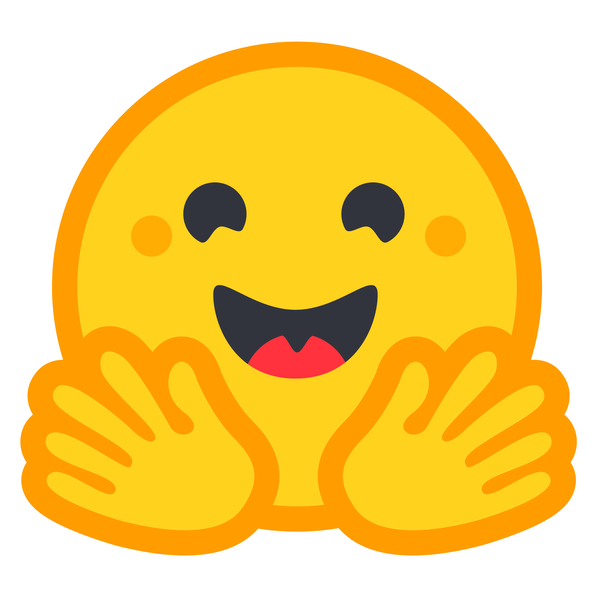

---

# <font color="blue">Оставьте отзыв о проделанной работе:</font>

---





### Оцените сложность работы (от 1 до 10)

Ответ:

### Оцените свой уровень освоения работы (от 1 до 10)

Отчет:

### Какие задания были выполнены?

Ответ:

### С какими заданиями были трудности? Опишите трудности.

Ответ:

### Сколько времени было затрачено на работу?

Ответ: